## Computational complexity of algorithms, accuracy and energy consumption


Pytorch hub vision models \
Models are pretrained on Imagenet dataset \
Finetuning for image classification task "ants or bees"

Epochs: 50 \
Batchsize: 16

Code for training in <https://github.com/MScDisseration/model_hub/tree/master/Training>


In order to get FLOP - used the pytorch module for profiling https://github.com/Lyken17/pytorch-OpCounter that returns the parameters and the MACs (multiply accumulate operation). \
MAC : a <- a + (b x c)
This module collects all the multiply operations and FLOPs is approximated to be double of MAC to account for other operations like add and divide. https://github.com/Lyken17/pytorch-OpCounter/tree/master/benchmark#macs-flops-what-is-the-difference  
Code in <https://github.com/MScDisseration/model_hub/blob/master/models.py>


In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from scipy import stats
from sklearn import metrics
from matplotlib import cm
from adjustText import adjust_text

%matplotlib inline
%config InlineBackend.figure_format='retina'

mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.size'] = 12

plt.style.use('tableau-colorblind10')

In [2]:
url = 'logs/models.txt'
df = pd.read_csv(url)

In [3]:
df.describe()

,macs,parameters
count,3.500000e+01,3.500000e+01
mean,6.351510e+09,5.052139e+07
std,6.685961e+09,5.508621e+07
min,4.252426e+07,1.235496e+06
25%,5.659043e+08,5.332784e+06
50%,4.111515e+09,2.383457e+07
75%,1.133300e+10,1.078390e+08
max,2.279560e+10,1.436782e+08


In [4]:
df['GFLOPS'] = (df['macs'] * 2) / (10 ** 9) 
df['TFLOPS'] = (df['macs'] * 2) / (10 ** 12)
df['Params(Million)'] = df['parameters'] / (10 ** 6)
df['Log'] = np.log(df['macs'])
df['Training 1 epoch(pfs-days)'] = df['GFLOPS'] * 2 * 3 * (1.2 * (10 ** 6))

In [5]:
print(df.GFLOPS.count())
df.head()

35


,model,macs,parameters,GFLOPS,TFLOPS,Params(Million),Log,Training 1 epoch(pfs-days)
0,alexnet,7.146919e+08,61100840.0,1.429384,0.001429,61.100840,20.387362,1.029156e+07
1,densenet121,2.865672e+09,7978856.0,5.731344,0.005731,7.978856,21.776069,4.126568e+07
2,densenet161,7.787013e+09,28681000.0,15.574026,0.015574,28.681000,22.775723,1.121330e+08
3,densenet169,3.398071e+09,14149480.0,6.796142,0.006796,14.149480,21.946474,4.893222e+07
4,densenet201,4.340971e+09,20013928.0,8.681942,0.008682,20.013928,22.191364,6.250998e+07


In [6]:
url = "logs/accuracy.csv" ##top 1 and top 5 error
df_accuracy = pd.read_csv(url)
print(df_accuracy.top1.count())

29


In [7]:
merge_df = df.merge(df_accuracy, on='model')

In [8]:
print(merge_df.top1.count())
merge_df.head()

29


,model,macs,parameters,GFLOPS,TFLOPS,Params(Million),Log,Training 1 epoch(pfs-days),top1,top5
0,alexnet,7.146919e+08,61100840.0,1.429384,0.001429,61.100840,20.387362,1.029156e+07,43.45,20.91
1,densenet121,2.865672e+09,7978856.0,5.731344,0.005731,7.978856,21.776069,4.126568e+07,25.35,7.83
2,densenet161,7.787013e+09,28681000.0,15.574026,0.015574,28.681000,22.775723,1.121330e+08,22.35,6.20
3,densenet169,3.398071e+09,14149480.0,6.796142,0.006796,14.149480,21.946474,4.893222e+07,24.00,7.00
4,densenet201,4.340971e+09,20013928.0,8.681942,0.008682,20.013928,22.191364,6.250998e+07,22.80,6.43


In [56]:
merge_df['top1score'] = 100 - merge_df['top1']
merge_df['top5score'] = 100 - merge_df['top5']

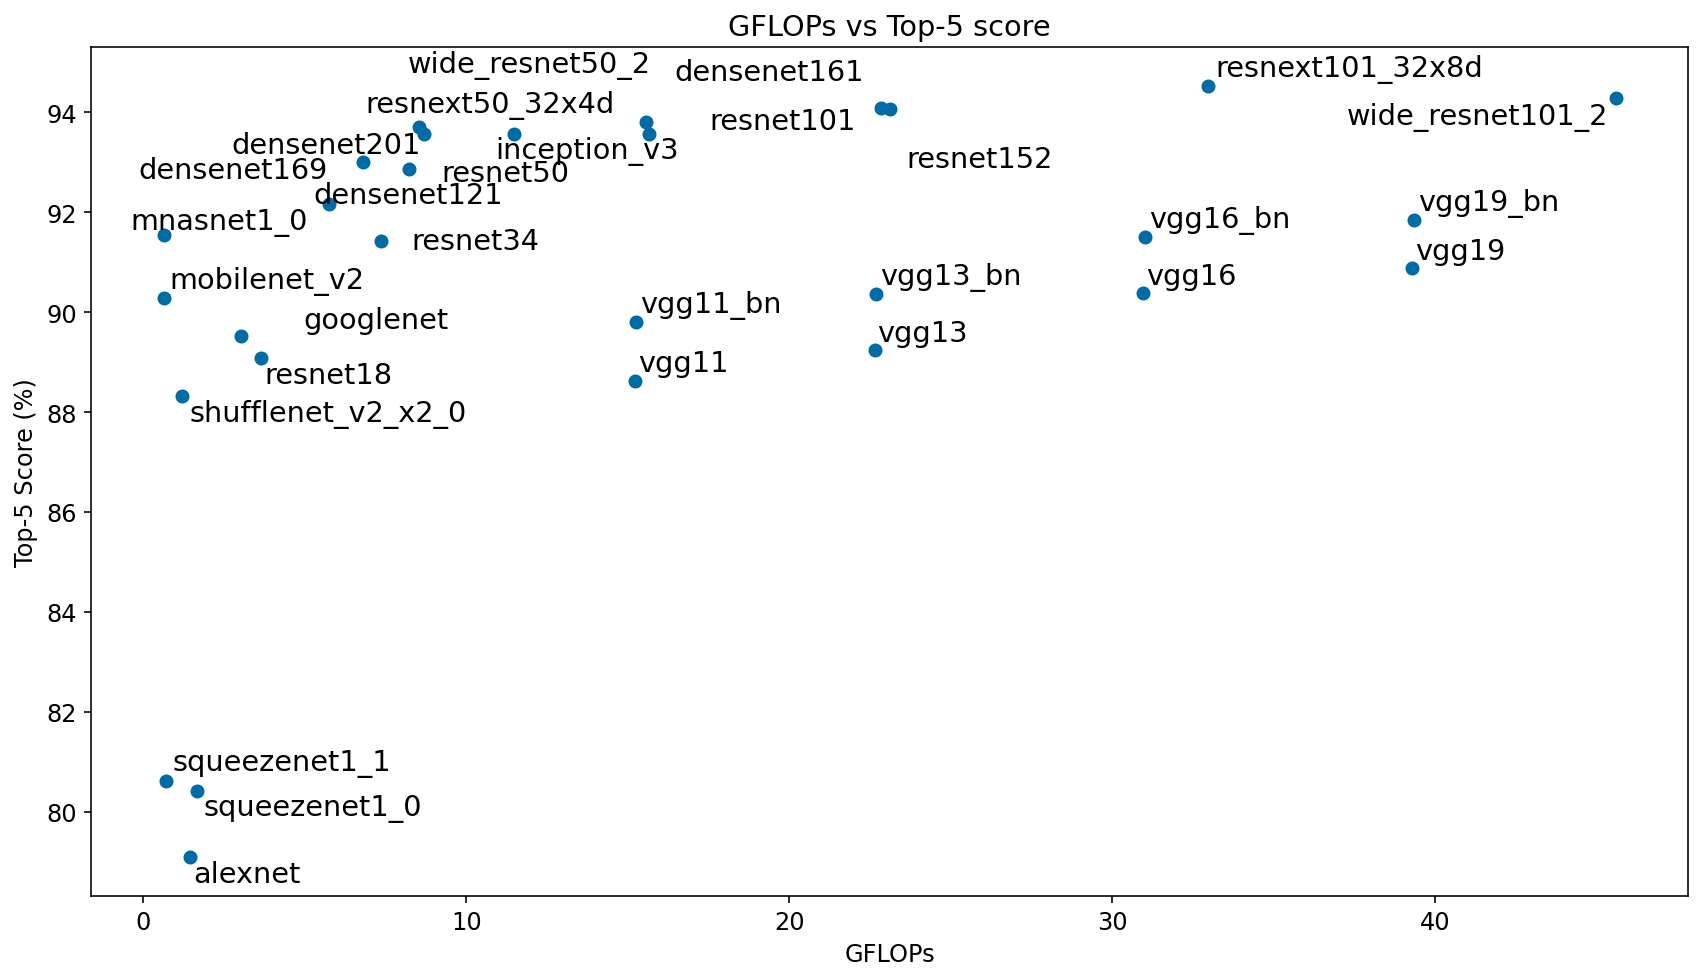

In [93]:
# needs citation https://github.com/Phlya/adjustText
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("GFLOPs")
ax.set_ylabel("Top-5 Score (%)")
ax.set_title("GFLOPs vs Top-5 score")

plt.scatter(merge_df['GFLOPS'], merge_df['top5score'])

#merge_df[['GFLOPS','top1','model']].apply(lambda row: ax.text(*row),axis=1);
texts = [ax.text(x, y, name,size='large') 
         for x, y, name in zip(merge_df['GFLOPS'],merge_df['top5score'],merge_df['model'])]

adjust_text(texts)
plt.tight_layout()
ax.figure.savefig('viz/fine-tunetop5.png',dpi=300)

In [59]:
x, y = merge_df['GFLOPS'],merge_df['top5score'] 
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print(f"slope {slope} \nintercept {intercept}\nr_value {r_value}\np_value {p_value}\nstd_err {std_err}")
print("R squared", r_value ** 2)

slope 0.13223517898807155 
intercept 88.54288366562055
r_value 0.4321136077428603
p_value 0.019237046397276962
std_err 0.053111265443602104
R squared 0.18672216999655053


The complexity measured in FLOPs does not necessarily improve the accuracy (or decrease the error).

However, within the same architecture, e.g., VGG and resnet, the error decreases linearly with FLOPs

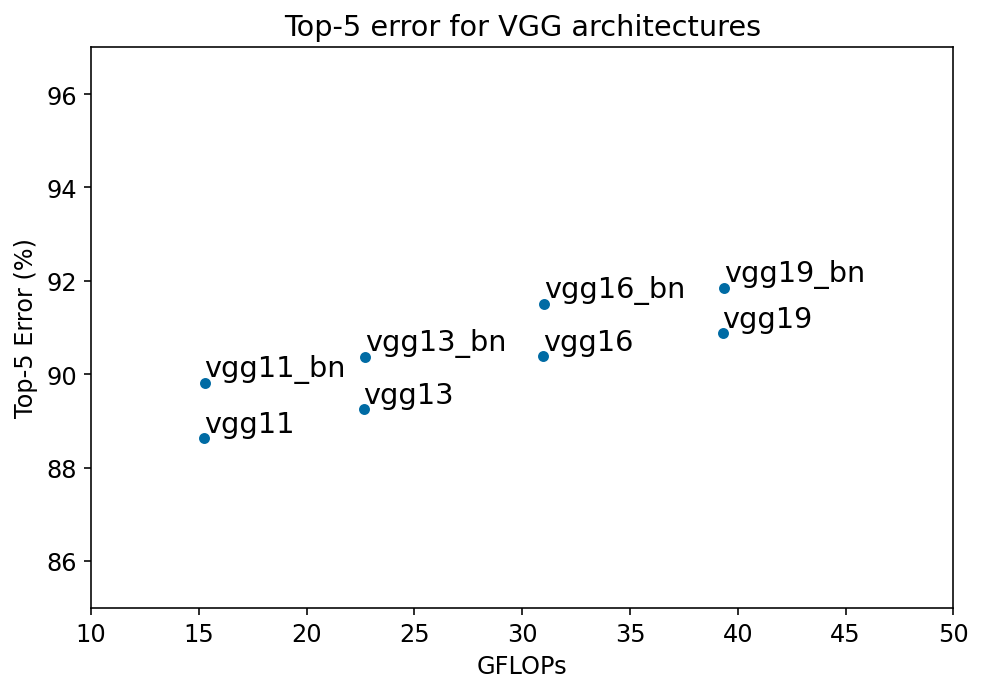

In [64]:
vggset = ['vgg11','vgg13','vgg16','vgg19','vgg11_bn','vgg13_bn','vgg16_bn','vgg19_bn']
vgg = merge_df.loc[merge_df.model.isin(vggset)]
ax = vgg.plot('GFLOPS', 'top5score', kind='scatter', figsize=(7,5))
ax.set_xlim(10,50)
ax.set_ylim(85,97)
ax.set_xlabel("GFLOPs")
ax.set_ylabel("Top-5 Error (%)")
ax.set_title("Top-5 error for VGG architectures")
vgg[['GFLOPS','top5score','model']].apply(lambda row: ax.text(*row,ha='left',va='bottom',size='large'),axis=1);
plt.tight_layout()
#ax.figure.savefig("viz/vggtop5error.png",dpi=300)

In [65]:
x, y = vgg['GFLOPS'],vgg['top5score'] 
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print(f"slope {slope} \nintercept {intercept}\nr_value {r_value}\np_value {p_value}\nstd_err {std_err}")
print("R squared", r_value ** 2)

slope 0.09405663894698407 
intercept 87.78875507349996
r_value 0.8313541476640554
p_value 0.01052576298537758
std_err 0.025668575213328392
R squared 0.691149718838228


## power monitor readings

In [66]:
df_reading = pd.read_csv("logs/finetune_pm_readings.csv")

In [67]:
df_reading['last_changed'] = pd.to_datetime(df_reading['last_changed'], errors='coerce')
df_reading.dropna(subset=['last_changed'], inplace=True)
df_reading.set_index('last_changed', inplace=True)

In [68]:
df_reading.tail()

,entity_id,node_id,power_consumption,unit
last_changed,,,,
2020-05-30 14:32:33.790128+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,16.784,W
2020-05-30 14:32:36.793057+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,16.675,W
2020-05-30 14:32:39.782380+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,16.729,W
2020-05-30 14:32:42.790067+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,16.778,W
2020-05-30 14:32:45.788001+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,16.794,W


In [69]:
df_time_interval = pd.read_csv("logs/finetune.csv")

In [70]:
print(df_time_interval.model.count())
df_time_interval.head()

20


,model,start_time,end_time
0,resnet18,2020-07-29 11:55:45.620879,2020-07-29 11:56:42.351618
1,resnet34,2020-07-29 11:56:42.723568,2020-07-29 11:57:55.600710
2,resnet50,2020-07-29 11:57:56.029574,2020-07-29 11:59:44.015472
3,resnet101,2020-07-29 11:59:44.778311,2020-07-29 12:02:22.085273
4,resnet152,2020-07-29 12:02:23.109644,2020-07-29 12:05:53.602304


In [71]:
df_time_interval['start_seconds']= [datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S.%f") - timedelta(hours=1, minutes=0)
                                  for start_time in df_time_interval.start_time]
df_time_interval['end_seconds'] = [datetime.strptime(end_time, "%Y-%m-%d %H:%M:%S.%f") - timedelta(hours=1, minutes=0)
                                for end_time in df_time_interval.end_time]
df_time_interval['total_time'] = df_time_interval['end_seconds'] - df_time_interval['start_seconds']
df_time_interval['total_time'] = df_time_interval['total_time'].apply(lambda x: x.total_seconds())
df_time_interval.head()

,model,start_time,end_time,start_seconds,end_seconds,total_time
0,resnet18,2020-07-29 11:55:45.620879,2020-07-29 11:56:42.351618,2020-07-29 10:55:45.620879,2020-07-29 10:56:42.351618,56.730739
1,resnet34,2020-07-29 11:56:42.723568,2020-07-29 11:57:55.600710,2020-07-29 10:56:42.723568,2020-07-29 10:57:55.600710,72.877142
2,resnet50,2020-07-29 11:57:56.029574,2020-07-29 11:59:44.015472,2020-07-29 10:57:56.029574,2020-07-29 10:59:44.015472,107.985898
3,resnet101,2020-07-29 11:59:44.778311,2020-07-29 12:02:22.085273,2020-07-29 10:59:44.778311,2020-07-29 11:02:22.085273,157.306962
4,resnet152,2020-07-29 12:02:23.109644,2020-07-29 12:05:53.602304,2020-07-29 11:02:23.109644,2020-07-29 11:05:53.602304,210.492660


In [72]:
df_time_interval['s_date'] = [x.date().strftime("%Y-%m-%d") for x in df_time_interval["start_seconds"]]
df_time_interval['e_date'] = [x.date().strftime("%Y-%m-%d") for x in df_time_interval["end_seconds"]]
df_time_interval['s_time'] = [x.time().strftime("%H:%M:%S") for x in df_time_interval["start_seconds"]]
df_time_interval['e_time'] = [x.time().strftime("%H:%M:%S") for x in df_time_interval["end_seconds"]]
df_time_interval.head()

,model,start_time,end_time,start_seconds,end_seconds,total_time,s_date,e_date,s_time,e_time
0,resnet18,2020-07-29 11:55:45.620879,2020-07-29 11:56:42.351618,2020-07-29 10:55:45.620879,2020-07-29 10:56:42.351618,56.730739,2020-07-29,2020-07-29,10:55:45,10:56:42
1,resnet34,2020-07-29 11:56:42.723568,2020-07-29 11:57:55.600710,2020-07-29 10:56:42.723568,2020-07-29 10:57:55.600710,72.877142,2020-07-29,2020-07-29,10:56:42,10:57:55
2,resnet50,2020-07-29 11:57:56.029574,2020-07-29 11:59:44.015472,2020-07-29 10:57:56.029574,2020-07-29 10:59:44.015472,107.985898,2020-07-29,2020-07-29,10:57:56,10:59:44
3,resnet101,2020-07-29 11:59:44.778311,2020-07-29 12:02:22.085273,2020-07-29 10:59:44.778311,2020-07-29 11:02:22.085273,157.306962,2020-07-29,2020-07-29,10:59:44,11:02:22
4,resnet152,2020-07-29 12:02:23.109644,2020-07-29 12:05:53.602304,2020-07-29 11:02:23.109644,2020-07-29 11:05:53.602304,210.492660,2020-07-29,2020-07-29,11:02:23,11:05:53


In [73]:
# def power_mean(s_date,e_date,s_time,e_time):
#     subset_df = df_reading.loc[s_date:e_date].between_time(s_time, e_time)[['power_consumption']]
#     return subset_df['power_consumption'].mean()


In [74]:
def energy_consumption(s_date,e_date,s_time,e_time):
    subset_df = df_reading.loc[s_date:e_date].between_time(s_time, e_time)[['power_consumption']]
    return ((subset_df['power_consumption']).sum() * 3) / (1000 * 3600)

In [75]:
for index, row in df_time_interval.iterrows(): 
    df_time_interval.at[index,'empirical'] = energy_consumption(row['s_date'],row['e_date'],
                                            row['s_time'],row['e_time'])

In [76]:
# for index, row in df_time_interval.iterrows(): 
#     df_time_interval.at[index,'mean_power'] = power_mean(row['s_date'],row['e_date'],
#                                             row['s_time'],row['e_time'])

In [77]:
# df_time_interval['power'] = df_time_interval['mean_power'] * df_time_interval['total_time']
# df_time_interval.head()

In [78]:
new_df = df_time_interval.merge(merge_df, on='model')
new_df.model.count()

20

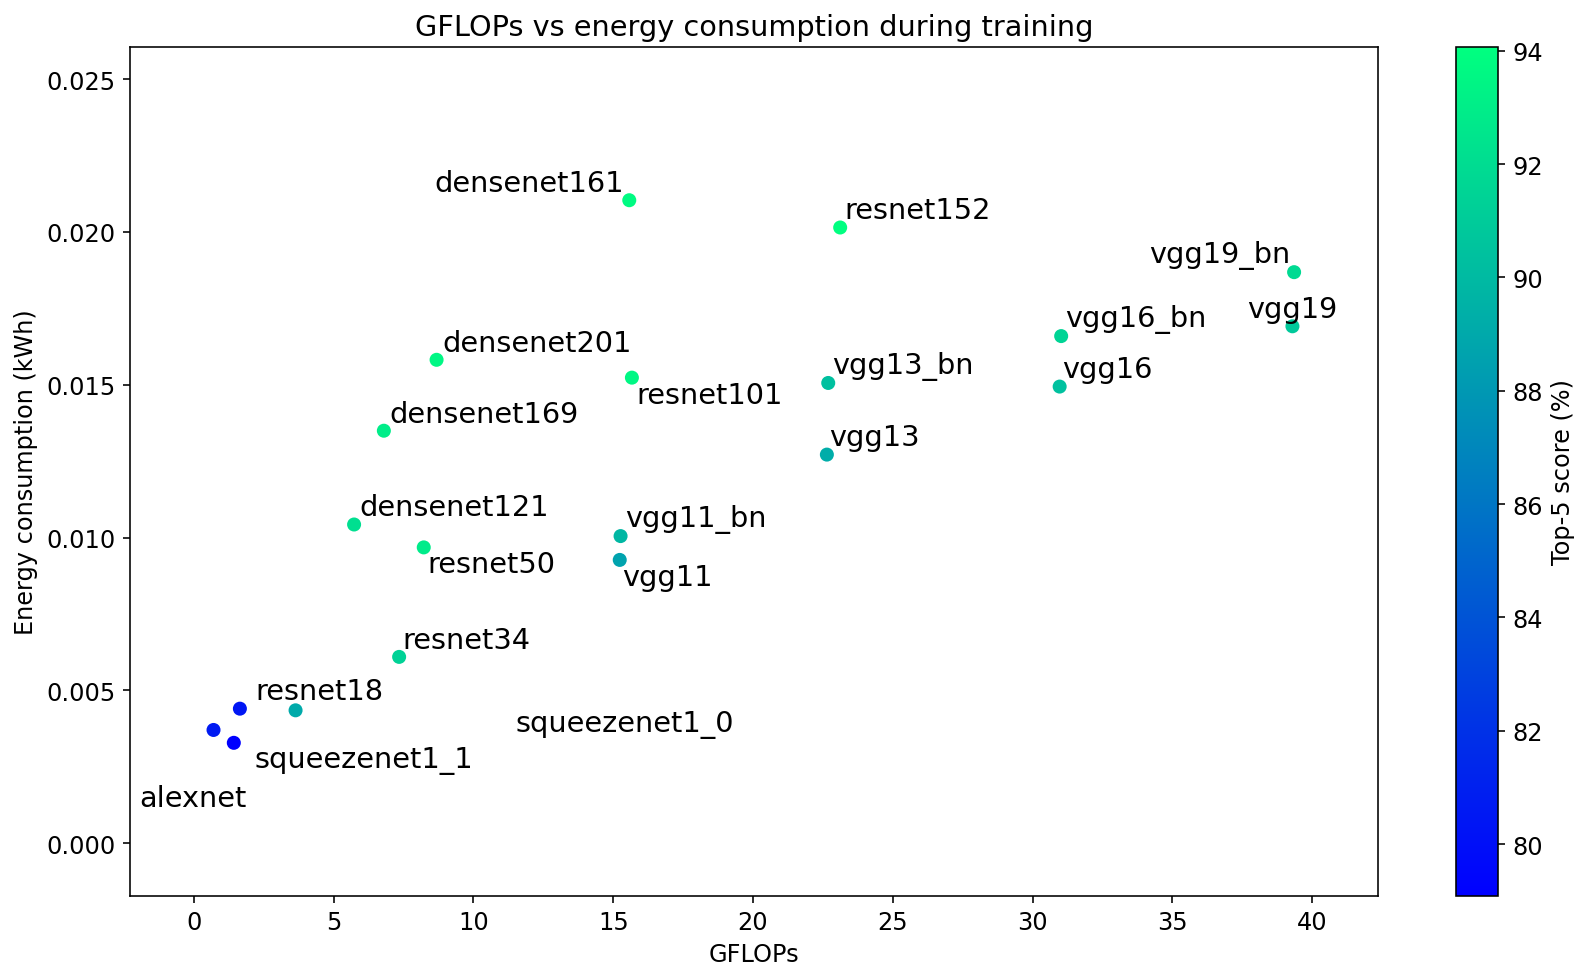

In [82]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("GFLOPs")
ax.set_ylabel("Energy consumption (kWh)")
ax.set_title("GFLOPs vs energy consumption during training")
cmap = cm.get_cmap('winter')
c = new_df['top5score']
plt.scatter(new_df['GFLOPS'], new_df['empirical'],
        c=c, cmap=cm.get_cmap('winter'))
plt.ylim(min(new_df['empirical'])- 0.005,max(new_df['empirical'])+0.005)
plt.xlim(min(new_df['GFLOPS'])- 3,max(new_df['GFLOPS'])+3)
texts = [ax.text(x, y, name,size='large') 
         for x, y, name in zip(new_df['GFLOPS'],new_df['empirical'],new_df['model'])]
cbar = plt.colorbar()
cbar.set_label('Top-5 score (%)')
adjust_text(texts)
plt.tight_layout()
ax.figure.savefig('viz/training_gflops_energy.png',dpi=300)

In [95]:
from scipy import stats
x = new_df['GFLOPS']
y = new_df['empirical'] 
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print(f"slope {slope} \nintercept {intercept}\nr_value {r_value}\np_value {p_value}\nstd_err {std_err}")
print('R squared ', r_value ** 2)
mse = metrics.mean_squared_error(x,y)
rmse = mse ** (1/2)
mae = metrics.mean_absolute_error(x, y)
print(f"rmse: {rmse} \nmae: {mae}")

slope 0.0003379715152277547 
intercept 0.006772710934972692
r_value 0.738822860031086
p_value 0.00019853020092928153
std_err 7.266056543775871e-05
R squared  0.5458592185045137
rmse: 19.76600098892701 
mae: 15.738790576441668


In [96]:
df_minus_densenet = new_df[new_df['model'].str.match(r'(^densenet.*)') == False]
df_minus_densenet.model.count()

16

In [130]:
from scipy import stats
x = df_minus_densenet['GFLOPS']
y = df_minus_densenet['empirical'] 
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print(f"slope {slope} \nintercept {intercept}\nr_value {r_value}\np_value {p_value}\nstd_err {std_err}")
print('R squared ', r_value ** 2)
mse = metrics.mean_squared_error(x,y)
rmse = mse ** (1/2)
mae = metrics.mean_absolute_error(x, y)
print(f"rmse: {rmse} \nmae: {mae}")

slope 0.0003907221729635673 
intercept 0.004526382391445618
r_value 0.8974308073620292
p_value 2.432486786735814e-06
std_err 5.133274728775647e-05
R squared  0.8053820540024635
rmse: 21.532193543002403 
mae: 17.37832148075


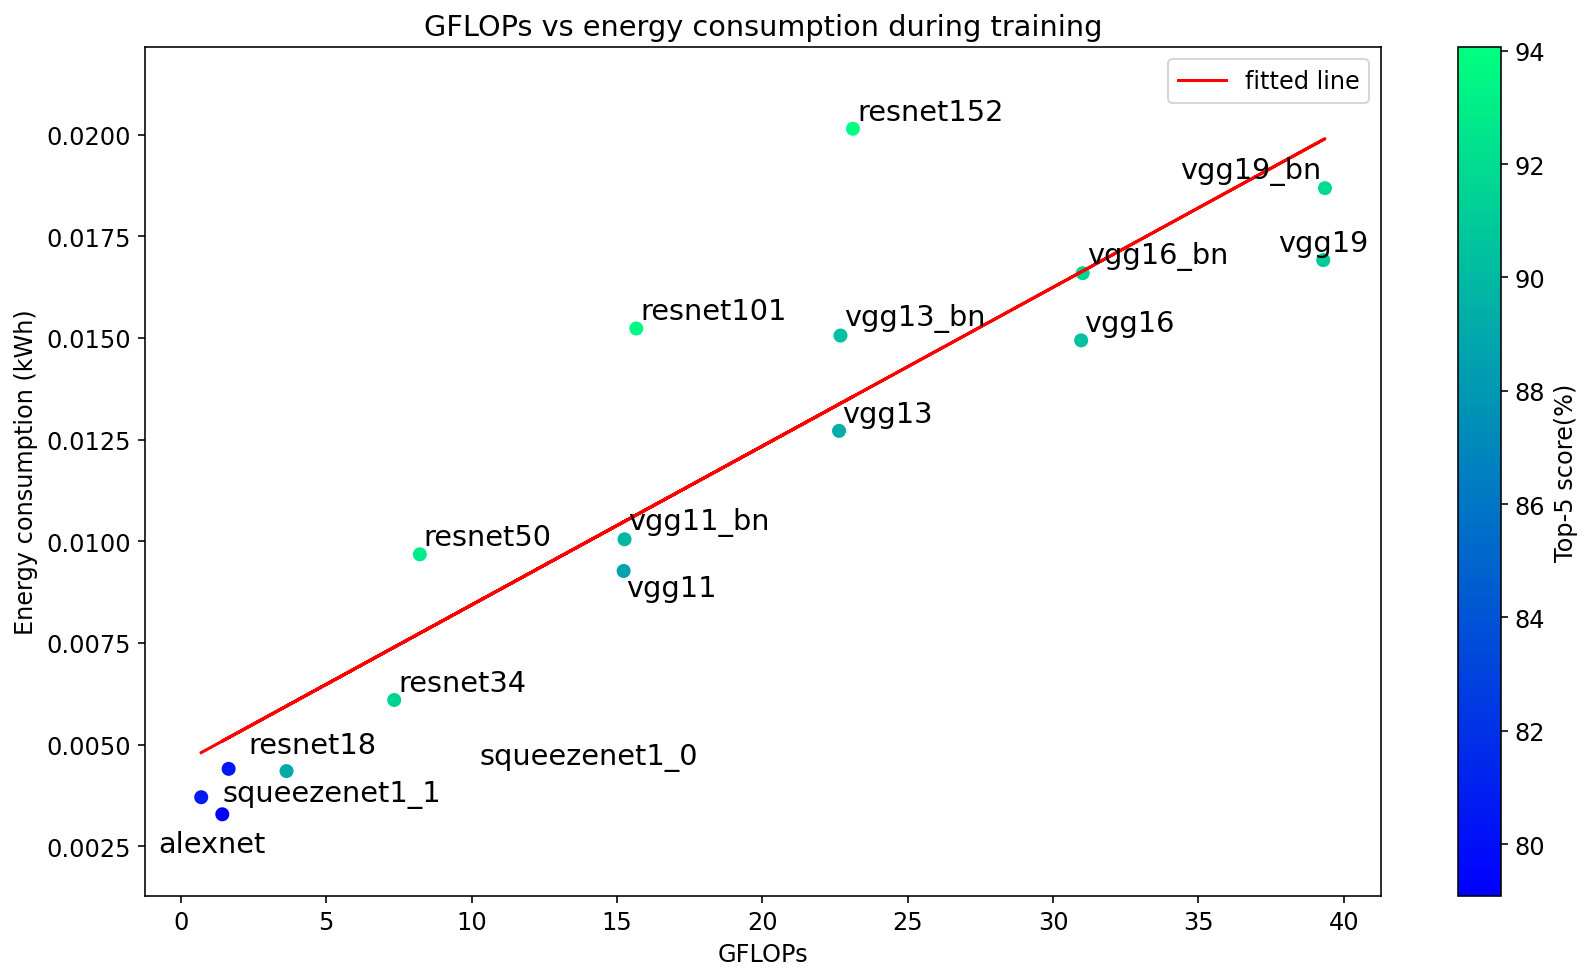

In [88]:
# ax = df_minus_densenet.plot('GFLOPS', 'empirical', kind='scatter',
#         c=range(len(df_minus_densenet)), colormap=cmap, figsize=(12,7),
#                   title="GFLOPs vs Energy Consumption during training")
# ax.set_xlabel("GFLOPs")
# ax.set_ylabel("Energy (kWh)")
# #merge_df[['GFLOPS','top1','model']].apply(lambda row: ax.text(*row),axis=1);
# texts = [ax.text(x, y, name,size='large') 
#          for x, y, name in zip(df_minus_densenet['GFLOPS'],df_minus_densenet['empirical'],df_minus_densenet['model'])]
# #ax.text(0.823441, 41.90, 'squeezenet1_0' )
# # needs citation https://github.com/Phlya/adjustText
# #colormap.remove()
# adjust_text(texts)
# plt.tight_layout()
# ax.figure.savefig('viz/training_removing_densenet.png',dpi=300)



fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("GFLOPs")
ax.set_ylabel("Energy consumption (kWh)")
ax.set_title("GFLOPs vs energy consumption during training")
cmap = cm.get_cmap('winter')
plt.ylim(min(df_minus_densenet['empirical'])- 0.002,max(df_minus_densenet['empirical'])+0.002)
c = df_minus_densenet['top5score']
plt.scatter(df_minus_densenet['GFLOPS'], df_minus_densenet['empirical'],
        c=c, cmap=cm.get_cmap('winter'))
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
texts = [ax.text(x, y, name,size='large') 
         for x, y, name in zip(df_minus_densenet['GFLOPS'],df_minus_densenet['empirical'],df_minus_densenet['model'])]
cbar = plt.colorbar()
cbar.set_label('Top-5 score(%)')
adjust_text(texts)
plt.legend()
plt.tight_layout()
ax.figure.savefig('viz/training_removing_densenet.png',dpi=300)

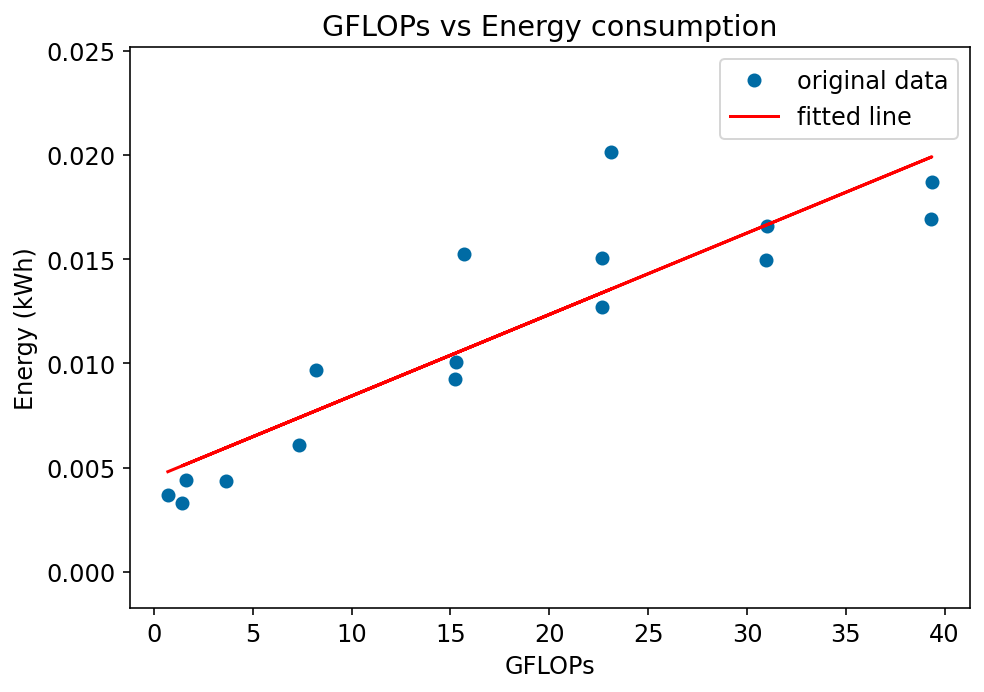

In [98]:
x = df_minus_densenet['GFLOPS']
y = df_minus_densenet['empirical']
plt.figure(figsize=(7,5))
plt.ylim(min(df_minus_densenet['empirical'])- 0.005,max(df_minus_densenet['empirical'])+0.005)
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.xlabel("GFLOPs")
plt.ylabel("Energy (kWh)")
plt.title("GFLOPs vs Energy consumption")
plt.legend()
plt.tight_layout()
plt.savefig('viz/training_fit_minus_densenet.png',dpi=300)

In [99]:
#merge_df

In [127]:
googlenet = merge_df[merge_df["model"] == "googlenet"]
wide_resnet50_2 = merge_df[merge_df["model"] == "wide_resnet50_2"]
vgg13 = merge_df[merge_df["model"] == "vgg13"]
vgg19 = merge_df[merge_df["model"] == "vgg19"]
mnasnet1_0 = merge_df[merge_df["model"] == "mnasnet1_0"]
googlenet["GFLOPS"].values

array([3.00975942])

In [131]:

energy = intercept + slope * googlenet["GFLOPS"].values[0]
print(f"googlenet : {energy}")

energy = intercept + slope * wide_resnet50_2["GFLOPS"].values[0]
print(f"wide_resnet50_2 : {energy}")


energy = intercept + slope * vgg13["GFLOPS"].values[0]
print(f"vgg13 : {energy}")

energy = intercept + slope * vgg19["GFLOPS"].values[0]
print(f"vgg19 : {energy}")

energy = intercept + slope * mnasnet1_0["GFLOPS"].values[0]
print(f"mnasnet1_0 : {energy}")

googlenet : 0.0057023621336884725
wide_resnet50_2 : 0.013455887967690419
vgg13 : 0.013372925734906867
vgg19 : 0.019879391899022616
mnasnet1_0 : 0.004780609017841287


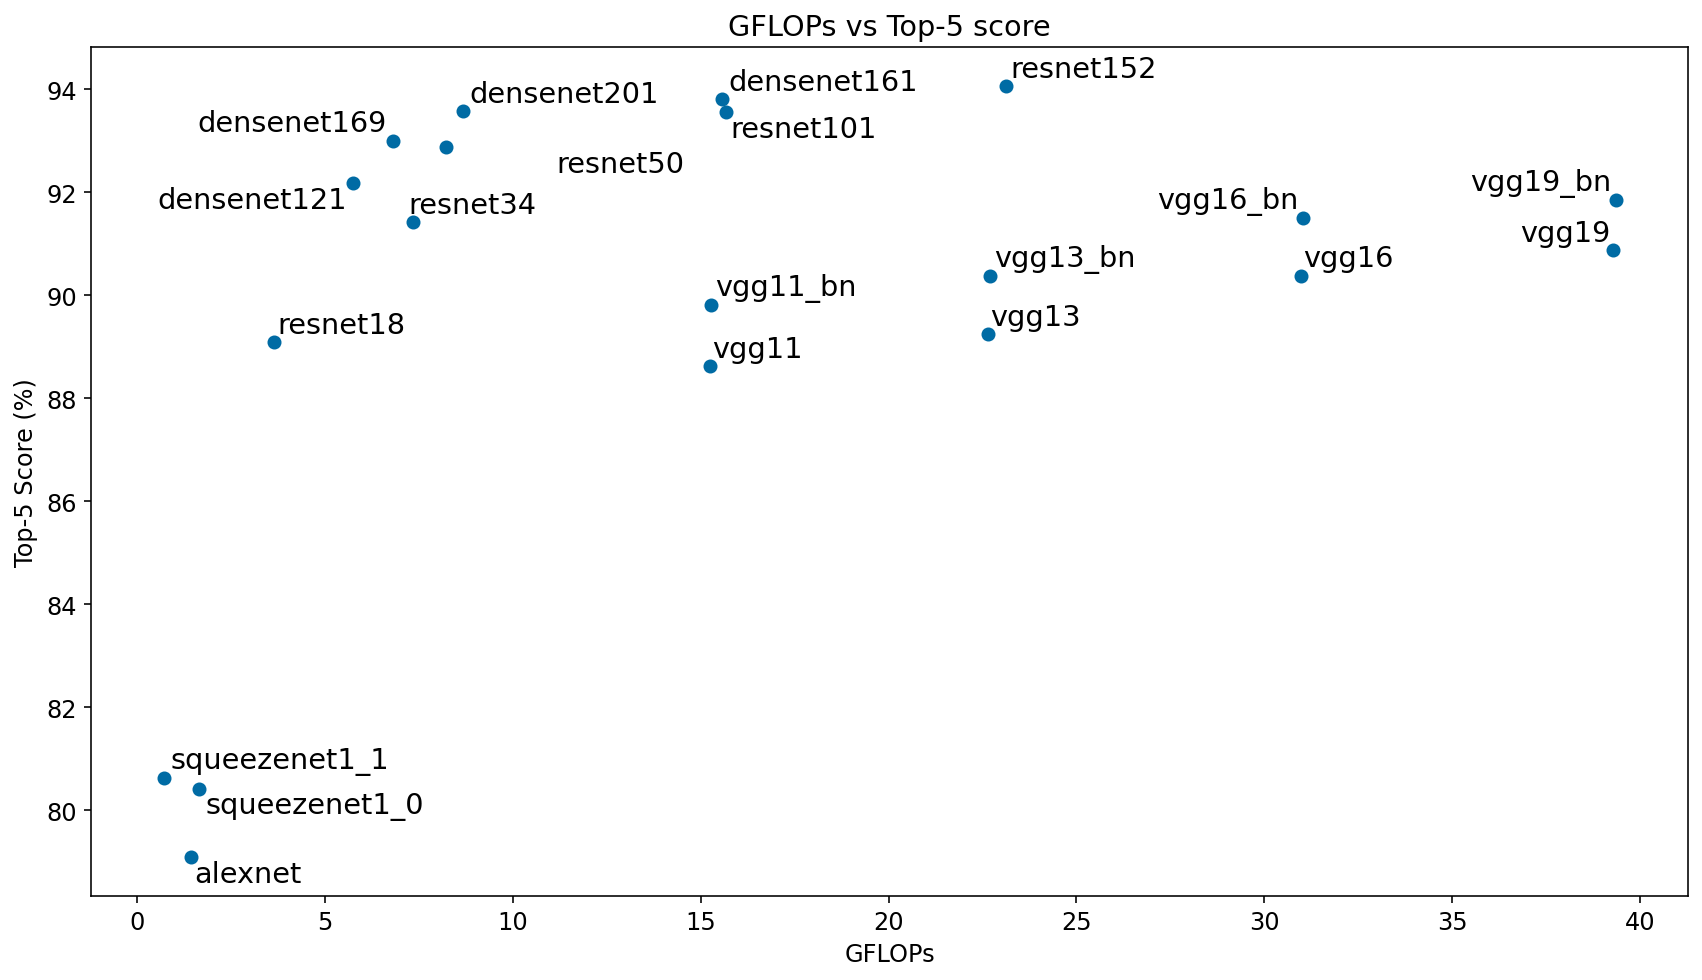

In [91]:
# fig = plt.figure(figsize=(12,7))
# ax = fig.add_subplot(1, 1, 1)
# ax.set_xlabel("GFLOPs")
# ax.set_ylabel("Top-5 Score (%)")
# ax.set_title("GFLOPs vs Top-5 score")

# plt.scatter(new_df['GFLOPS'], new_df['top5score'])

# #merge_df[['GFLOPS','top1','model']].apply(lambda row: ax.text(*row),axis=1);
# texts = [ax.text(x, y, name,size='large') 
#          for x, y, name in zip(new_df['GFLOPS'],new_df['top5score'],new_df['model'])]

# adjust_text(texts)
# plt.tight_layout()
# ax.figure.savefig('viz/fine-tunetop5.png',dpi=300)

In [102]:
# x, y = new_df['GFLOPS'],new_df['top5score'] 
# slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
# print(f"slope {slope} \nintercept {intercept}\nr_value {r_value}\np_value {p_value}\nstd_err {std_err}")
# print("R squared", r_value ** 2)

## time and flops

In [103]:
from scipy import stats
x = df_minus_densenet['GFLOPS']
y = df_minus_densenet['total_time'] 
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print(f"slope {slope} \nintercept {intercept}\nr_value {r_value}\np_value {p_value}\nstd_err {std_err}")
print('R squared ', r_value ** 2)
mse = metrics.mean_squared_error(x,y)
rmse = mse ** (1/2)
mae = metrics.mean_absolute_error(x, y)
print(f"rmse: {rmse} \nmae: {mae}")

slope 3.6733961382773055 
intercept 59.00987145293785
r_value 0.8954560154215152
p_value 2.7648818518586143e-06
std_err 0.4880517437926988
R squared  0.8018414755545769
rmse: 113.25008887308121 
mae: 105.499274243


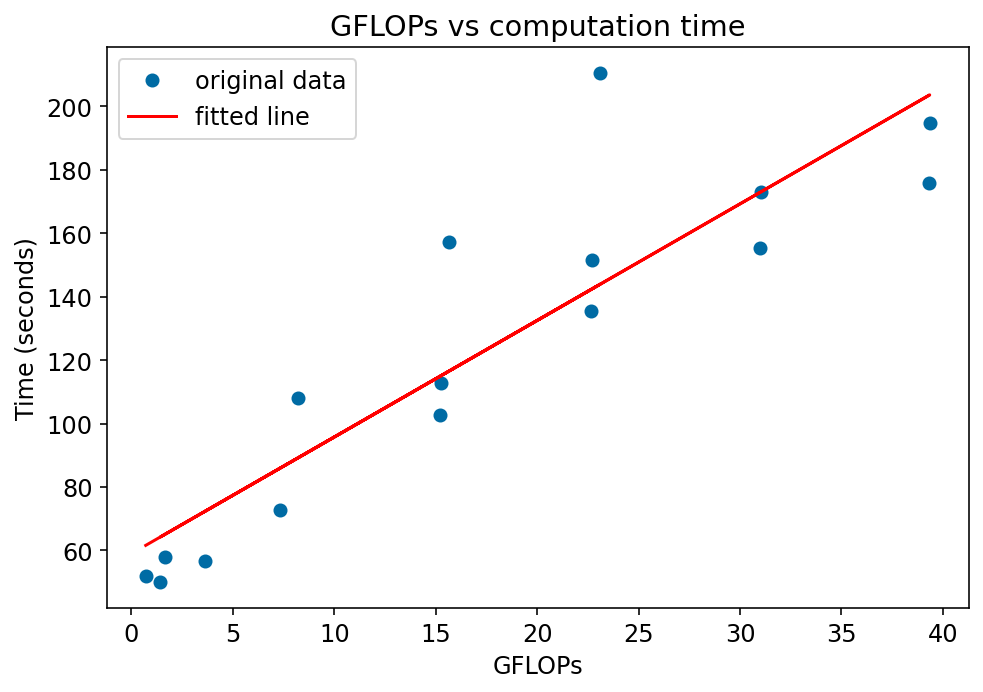

In [104]:
x = df_minus_densenet['GFLOPS']
y = df_minus_densenet['total_time']
plt.figure(figsize=(7,5))
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.xlabel("GFLOPs")
plt.ylabel("Time (seconds)")
plt.title("GFLOPs vs computation time")
plt.legend()
plt.tight_layout()
plt.savefig('viz/time_vs_gflops.png',dpi=300)

## parameters and flops

In [105]:
from scipy import stats
x = df_minus_densenet['GFLOPS']
y = df_minus_densenet['Params(Million)'] 
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print(f"slope {slope} \nintercept {intercept}\nr_value {r_value}\np_value {p_value}\nstd_err {std_err}")
print('R squared ', r_value ** 2)
mse = metrics.mean_squared_error(x,y)
rmse = mse ** (1/2)
mae = metrics.mean_absolute_error(x, y)
print(f"rmse: {rmse} \nmae: {mae}")

slope 3.6865229828293082 
intercept 18.597291695574413
r_value 0.8268112896548602
p_value 7.822802224390286e-05
std_err 0.6702752177795449
R squared  0.6836169087007331
rmse: 80.31753294054849 
mae: 65.364772824


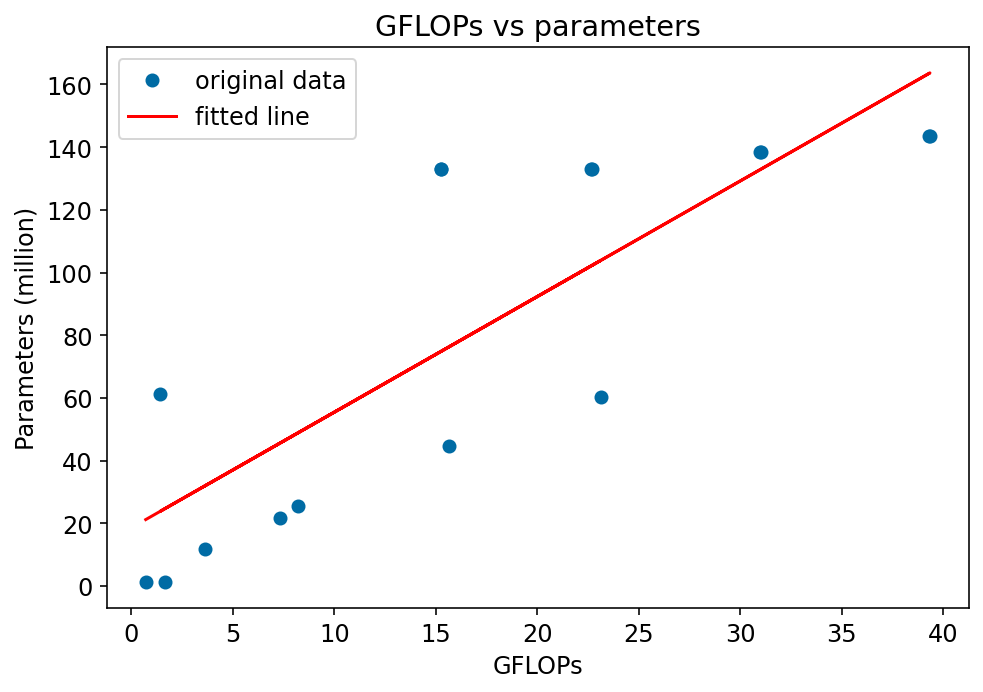

In [106]:
x = df_minus_densenet['GFLOPS']
y = df_minus_densenet['Params(Million)']
plt.figure(figsize=(7,5))
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.xlabel("GFLOPs")
plt.ylabel("Parameters (million)")
plt.title("GFLOPs vs parameters")
plt.legend()
plt.tight_layout()
plt.savefig('viz/parameters_vs_gflops.png',dpi=300)

## parameters vs energy

In [107]:
from scipy import stats
x = df_minus_densenet['Params(Million)']
y = df_minus_densenet['empirical'] 
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print(f"slope {slope} \nintercept {intercept}\nr_value {r_value}\np_value {p_value}\nstd_err {std_err}")
print('R squared ', r_value ** 2)
mse = metrics.mean_squared_error(x,y)
rmse = mse ** (1/2)
mae = metrics.mean_absolute_error(x, y)
print(f"rmse: {rmse} \nmae: {mae}")

slope 6.402316061662627e-05 
intercept 0.006025890848280886
r_value 0.6556628456998114
p_value 0.005822805884261936
std_err 1.9704726552444476e-05
R squared  0.4298937672311747
rmse: 100.2671716267061 
mae: 82.69328709875


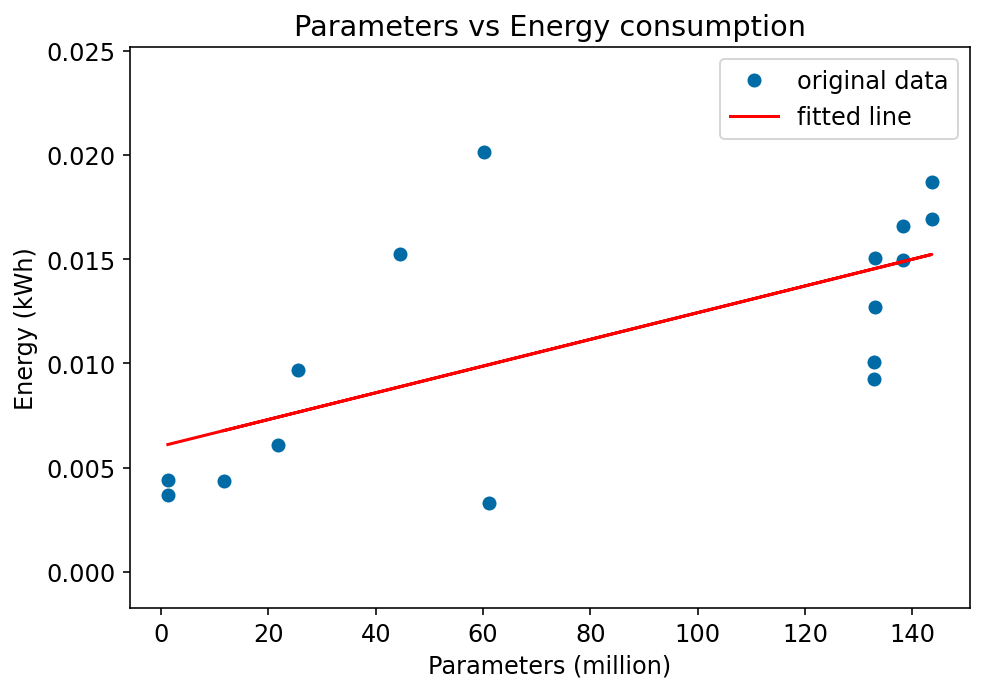

In [108]:
x = df_minus_densenet['Params(Million)']
y = df_minus_densenet['empirical']
plt.figure(figsize=(7,5))
plt.ylim(min(df_minus_densenet['empirical'])- 0.005,max(df_minus_densenet['empirical'])+0.005)
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.xlabel("Parameters (million)")
plt.ylabel("Energy (kWh)")
plt.title("Parameters vs Energy consumption")
plt.legend()
plt.tight_layout()
plt.savefig('viz/param_vs_energy.png',dpi=300)

## vgg architecture

In [109]:
vgg_df = df_time_interval.merge(vgg, on='model')

In [110]:
#ax = vgg_df.plot('GFLOPS', 'power', kind='scatter')
slope, intercept, r_value, p_value, std_err = stats.linregress(vgg_df['GFLOPS'],vgg_df['empirical'] )
print(f"slope {slope} \nintercept {intercept}\nr_value {r_value}\np_value {p_value}\nstd_err {std_err}")
print('R squared ', r_value ** 2)

slope 0.00032465657456369815 
intercept 0.005495021542591606
r_value 0.9354802486508114
p_value 0.0006393843828560281
std_err 5.006735732383812e-05
R squared  0.8751232956157838


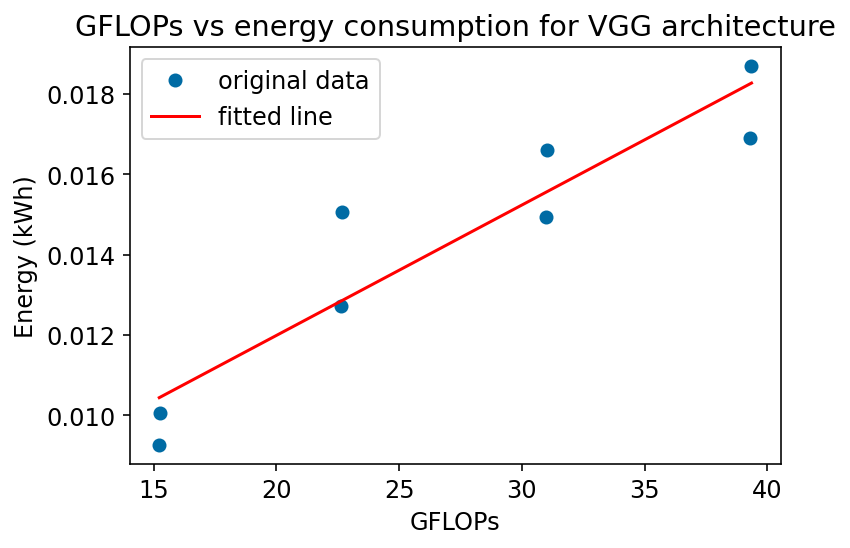

In [111]:
x = vgg_df['GFLOPS']
y = vgg_df['empirical']
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.xlabel("GFLOPs")
plt.ylabel("Energy (kWh)")
plt.title("GFLOPs vs energy consumption for VGG architecture")
plt.legend()
plt.tight_layout()
plt.savefig('viz/training_vgg_gflops_power_fit.png',dpi=300)

## data for appendix

In [112]:

df_co2 = pd.read_csv("../BERT/results/co2data.csv")
uk_co2 = df_co2.loc[df_co2.country == 'United Kingdom'].impact.mean()

new_df['CO2e'] = uk_co2 * df_time_interval['empirical']
new_df['kg CO2e'] = new_df['CO2e'] /1000

In [113]:
features = ['model','GFLOPS','empirical','kg CO2e','top1score','top5score']
cv_training = new_df[features]
cv_training.to_csv("results/cv_training.csv", index=False)

In [114]:
cv_training

,model,GFLOPS,empirical,kg CO2e,top1score,top5score
0,resnet18,3.638133,0.004348,0.001100,69.76,89.08
1,resnet34,7.342526,0.006096,0.001542,73.30,91.42
2,resnet50,8.223029,0.009680,0.002449,76.15,92.87
3,resnet101,15.667943,0.015235,0.003854,77.37,93.56
4,resnet152,23.117674,0.020149,0.005098,78.31,94.06
5,alexnet,1.429384,0.003284,0.000831,56.55,79.09
6,vgg11,15.233133,0.009270,0.002345,69.02,88.63
7,vgg11_bn,15.262837,0.010050,0.002543,70.38,89.81
8,vgg13,22.641519,0.012716,0.003217,69.93,89.25
9,vgg13_bn,22.690490,0.015061,0.003810,71.55,90.37


In [115]:
# energy difference between vgg19 and vgg11
(0.016916 - 0.009270) /0.009270

0.8248112189859762

In [116]:
# accuracy difference
(11.37 - 9.12)/11.37

0.1978891820580475

from \cite{Ren2019}

In [117]:
bertflops = 2.87 * 2

In [118]:
slope =0.0003907221729635673 
intercept =0.004526382391445618
energy = intercept + slope * bertflops
print(f"energy {energy}")

energy 0.006769127664256494
